### Introduction

In [this notebook](https://gitlab.cern.ch/sterbini/lhcmaskdoc/-/blob/master/docs/ipynbs/python_example/Pythonic_approach.ipynb), we are aiming to use python as scripting language for the MAD-X mask. The goal is to bring together the scripting flexibility of python and the optics capability from MAD-X.

The rationale is to use [cpymad](https://github.com/hibtc/cpymad) to interface python to MAD-X.

Beyond the standard python setup, to run this notebook you need the following packages
```bash
pip install cpymad   
pip install madxp
pip install pyarrow # this is needed to save file in parquet format
```

In addition you need AFS mounted and access to 
```bash
/afs/cern.ch/eng/lhc/optics/
/afs/cern.ch/eng/tracking_tools
/afs/cern.ch/user/s/sterbini/public/tracking_tools   # to be replaced once consolidated
```
that you should already have.

!!! warning
    We assume that the user knows MAD-X and python.

In [1]:
# check to verify the access
!ls /afs/cern.ch/eng/tracking-tools/

beambeam_macros  errors  machines  modules  python_installations  tools


#### Importing the packages

In [2]:
from cpymad.madx import Madx
from madxp import cpymadTool as mt
from collections import OrderedDict
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from IPython.display import display
import time
import os
import warnings
import shutil
warnings.filterwarnings('always')

### Mask parameters

In the **parameter_dict** we will store the parameters needed for simulation.

!!! warning
    Remember that MAD-X does not accept "strings" as variables.

In [3]:
# %% Definition of the parameters that are not knobs of the beam sequence (no strings please!)
parameter_dict={
    # =============================================================================
    # Beam parameters
    # =============================================================================
    ## LHC beam 1 (clockwise), LHC beam 2 (clockwise), LHC beam 2 (counterclockwise) 
    'par_mylhcbeam': 1, 
    ## beam normalized emittance [m rad]
    'par_beam_norm_emit': 2.5e-6,
    ## [m]
    'par_beam_sigt': 0.075,
    ## [-]           
    'par_beam_sige': 1.1e-4,
    ## [-]                    
    'par_beam_npart': 1.16e11, 
    ## [GeV]            
    'par_beam_energy_tot': 7000,
    ## [A]          
    'par_oct_current': 350,
    ## [-]            
    'par_chromaticity': 15,
    ## [MV]          
    'par_vrf_total': 16.,
    ## Tunes with fractional part          
    'par_qx0': 62.31, 'par_qy0': 60.32,
    # =============================================================================
    # Beam-Beam configuration 
    # =============================================================================
    ## install the BB elements [0,1]
    'par_on_bb_switch': 1,
    ## if 1 lumi leveling in ip8 is applied and q/q' match is done with bb off [0,1]
    'par_on_collision': 1, 
    ## bunch separation [ns]               
    'par_b_t_dist': 25.,   
    ## default value for the number of additionnal parasitic encounters inside D1              
    'par_n_inside_D1': 5,                 
    ## number of slices for head-on in IR1 [between 0 and 201]
    'par_nho_IR1': 11, 'par_nho_IR2': 11, 'par_nho_IR5': 11, 'par_nho_IR8': 11, 
    ## flag to install the Crab Cavities [0, 1]
    'par_install_crabcavities': 0,
    # can be negative positive or zero to switch of spectr in lhcb
    'par_lhcb_polarity': 1., 
    # =============================================================================
    # Leveling in IP8   
    # =============================================================================
    # leveled luminosity in IP8 (considered if par_on_collision=1) [Hz/cm2]
    'par_lumi_ip8': 2e33,                 
    # These variables define the number of Head-On collisions in the 4 IPs
    'par_nco_IP1': 2592, 'par_nco_IP2': 2288, 'par_nco_IP5': 2592, 'par_nco_IP8': 2396,
    # =============================================================================
    # Errors and corrections 
    # =============================================================================
    # Select seed for errors
    'par_myseed': 0,
    # Set this flag to correct the errors of D2 in the NLC 
    # (warning: for now only correcting b3 of D2, still in development)
    'par_correct_for_D2': 0,
    # Set this flag to correct the errors of MCBXF in the NLC 
    # (warning: this might be less reproducable in reality, use with care)
    'par_correct_for_MCBX': 0,
    'par_off_all_errors': 0,
    'par_on_errors_LHC': 0,
    'par_on_errors_MBH': 0,
    'par_on_errors_Q5': 0,
    'par_on_errors_Q4': 0,
    'par_on_errors_D2': 0,
    'par_on_errors_D1': 0,
    'par_on_errors_IT': 0,
    'par_on_errors_MCBRD': 0,
    'par_on_errors_MCBXF': 0,
    # =============================================================================
    # Additional parameters
    # =============================================================================
    # parameter for having verbose output [0,1]
    'par_verbose': 1,
    # definition of the slicefactor used in the makethin
    'par_slicefactor': 4,
    # number of optics to use
    'par_optics_number':30,
    # Specify machine version
    'ver_lhc_run' : 3, 'ver_hllhc_optics' : 0,
}

#### Masked parameters

To remain compatible with the "legacy" work-flow, we maintain the concept of masked variables, even in a pure pythonic approach the concept masked variable has a weaker use-case.

In [4]:
# In this cell we read "masked_variables.txt" and we load the variable to a mask_dict
mask_dict={}
try:
    with open('masked_variables.txt', 'r') as parameter_file:
        for l in parameter_file:  
            parameter , value = l.strip().split('=')
            # forcing lower case for the parameter
            # forcing float for the values
            mask_dict[parameter.strip().lower()]=float(value.strip()) 
        print('File "masked_variables.txt" found.')
except FileNotFoundError:
    print('File "masked_variables.txt" not found. Custom data are assumed.')

# If a variable, prensent in mask_dict, is present also in parameter_dict 
# then it is overwritten on parameter_dict. 
for i in mask_dict.keys():
    if i in parameter_dict.keys():
        print(f'Re-assign {i}')
        parameter_dict[i]=mask_dict[i]

File "masked_variables.txt" found.
Re-assign par_verbose
Re-assign par_mylhcbeam
Re-assign par_optics_number


### The make_sequence function

The user has to define a "make_sequence" function. The function will take the MAD-X handle, the beam number (1, 2 or 4) and, in this case, the slice factor (to make the sequence thin). 

!!! info
    It is important to know that we clearly define an interface that isolate the function from MAD-X.
    
!!! hint 
    Take the time to consider the different ```madx.call```.
    
!!! info
    This function refers to links (e.g., ```macro.madx```) that will be defined later.

In [5]:
def make_sequence(mad, mylhcbeam, slicefactor):
    '''
    User-defined function to make the Run3 optics.
    '''
    
    start_time = time.time()
    
    mad.input('option, -echo,warn, -info;')
    # optics dependent macros
    mad.call('macro.madx') 
    # optics dependent macros
    mad.call('optics_indep_macros.madx')

    assert mylhcbeam in [1, 2, 4], "Invalid mylhcbeam (it should be in [1, 2, 4])"

    if mylhcbeam in [1, 2]:
        mad.call('optics_runII/2018/lhc_as-built.seq')
    else:
        mad.call('optics_runII/2018/lhcb4_as-built.seq')

    # New IR7 MQW layout and cabling
    mad.call('optics_runIII/RunIII_dev/IR7-Run3seqedit.madx')
    
    # Makethin part
    if slicefactor > 0:
        mad.input(f'slicefactor={slicefactor};') # the variable in the macro is slicefactor
        mad.call('optics_runII/2018/toolkit/myslice.madx')
        mad.beam()
        for my_sequence in ['lhcb1','lhcb2']:
            if my_sequence in list(mad.sequence):
                mad.input(f'use, sequence={my_sequence}; makethin, sequence={my_sequence}, style=teapot, makedipedge=false;')
    else:
        warnings.warn('The sequences are not thin!')

    # Cycling w.r.t. to IP3 (mandatory to find closed orbit in collision in the presence of errors)
    for my_sequence in ['lhcb1','lhcb2']:
        if my_sequence in list(mad.sequence):
            mad.input(f'seqedit, sequence={my_sequence}; flatten; cycle, start=IP3; flatten; endedit;')

    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

### The load_optics function

This is the (very simple) function to load the the optics file.

!!! info
    This function refers to links (e.g., ```optics.madx```) that will be defined later.
    
!!! hint
    We prefer to use links more than variables so that, in the folder of the simulation you have (at least some of) the links used from your mask.

In [6]:
def load_optics(mad):
    '''
    User-defined function load the optics file.
    '''
    start_time = time.time()
    
    # nothing very special
    mad.call(f'optics.madx')
    
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

### Auxiliary functions 

To improve the analysis and debugging of the mask is useful to have some auxiliary functions.
!!! info
    We plan to move them to a package.
    
!!! warning
    Please check the files that will be removed by the **clean_folder** function.

In [7]:
def get_status(mad):
    '''
    Return the status of the variables, sequences, beams and tables of a MAD-X object (mad).
    '''
    start_time = time.time()
    
    variables=mt.variables_dict(mad)
    
    my_output_dict= {'constant_df': variables['constant_df'],
            'independent_variable_df': variables['independent_variable_df'],
            'dependent_variable_df': variables['dependent_variable_df'],
            'sequences_df': mt.sequences_df(mad),
            'beams_df': mt.beams_df(mad),
            'tables_list': list(mad.table)}
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time'] = elapsed_time
    return my_output_dict

def run_module(mad, module_name):
    '''
    Run the module_name in the MAD-X object (mad).
    '''
    start_time = time.time()
    
    mad.call(f'modules/{module_name}')
    
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time']= elapsed_time
    return my_output_dict

def read_parameters(mad, parameter_dict):
    '''
    Assign the parameter_dict to the MAD-X object (mad).
    '''
    start_time = time.time()
    
    parameter_dict['par_qx00']=int(parameter_dict['par_qx0'])
    parameter_dict['par_qy00']=int(parameter_dict['par_qy0'])
    parameter_dict['par_tsplit']=parameter_dict['par_qx00']-parameter_dict['par_qy00']
    
    assert parameter_dict['par_nco_IP5']==parameter_dict['par_nco_IP1']
    assert parameter_dict['par_qx00']-parameter_dict['par_qy00']==parameter_dict['par_tsplit']
    assert 'par_mylhcbeam' in parameter_dict
    assert 'par_beam_norm_emit' in parameter_dict
    assert 'par_optics_number' in parameter_dict, 'Optics file not defined.'

    for i in parameter_dict:
        if isinstance(parameter_dict[i], (float,int)):
            mad.input(f'{i}={parameter_dict[i]};')
   
    my_output_dict = get_status(mad)
    elapsed_time = time.time() - start_time
    my_output_dict['elapsed_time']= elapsed_time
    return my_output_dict

def clean_folder(file_string='fc.* *parquet twiss* log.madx stdout.madx bb_lenses.dat last_twiss.0.gz temp', rm_links=True):
    '''
    Remove the folder from the MAD-X output.
    '''
    if rm_links:
        os.system('find -type l -delete')
    os.system('rm -rf '+ file_string)

def check_links(my_path='.'):
    '''
    Checks the validity of the links.
    '''
    symlinks = [i for i in os.listdir(my_path)]
    for i in symlinks:
        if os.path.islink(i):
            assert os.path.exists(i), f'Link to {i} is broken.'

### Make links

!!! warning
    Establish the correct links is very important since the links are directly used in the python functions and in the MAD-X modules. 
    
!!! warning
    The link to the ```/afs/cern.ch/user/s/sterbini/public/tracking_tools/modules``` will be removed once the folder will be merged with te official repository ```/afs/cern.ch/eng/tracking-tools/modules```.

In [8]:
#%% Make links for setting the enviroments
clean_folder()
# Main path
os.symlink('/afs/cern.ch/eng/tracking-tools', 'tracking_tools')
# Mask code folder
os.symlink('/afs/cern.ch/user/s/sterbini/public/tracking_tools/modules', 'modules')
# Machine folder
os.symlink('tracking_tools/machines', 'machines')
# Toolkit folder
os.symlink('tracking_tools/tools', 'tools')
# Beam-beam macros folder
os.symlink('tracking_tools/beambeam_macros', 'beambeam_macros')
# Errors folder
os.symlink('tracking_tools/errors', 'errors')
# RunII optics
os.symlink('/afs/cern.ch/eng/lhc/optics/runII', 'optics_runII')
# RunIII optics
os.symlink('/afs/cern.ch/eng/lhc/optics/runIII', 'optics_runIII')
# Load optics (magnet strengths)
op  = int(parameter_dict['par_optics_number'])
os.symlink(f'optics_runIII/RunIII_dev/2022_V1/PROTON/opticsfile.{op}', 'optics.madx')

# General macros
# optics dependent macros
#os.symlink('optics_runII/2018/toolkit/macro.madx', 'macro.madx')
os.symlink('/afs/cern.ch/work/s/sterbini/tracking_tools/tools/macro.madx', 'macro.madx')

# optics independent macros
os.symlink('tools/optics_indep_macros.madx', 'optics_indep_macros.madx')
check_links()

### Launch MAD-X from python

In [9]:
command_log_file='log.madx'
stdout_file='stdout.madx'
with open(stdout_file, 'w') as myFile:
    mad = Madx(stdout=myFile,command_log=command_log_file)

# for completness and in case, one need to change the working_folder
working_folder='.'
os.chdir(working_folder)

### Preliminary optics checks

In the following cell we execute the functions

    - read_parameters
    - make_sequence
    - load_optics

then we run the module ```module_00_check_optics.madx```.

In a similar way we could ran all the remaing module of the mask. Before executing them we will analyze and do sanity checks on the optics.

!!! info
    While executing the code we build up a work-flow dictionary (```my_workflow_dict```). Indeed, all the fuction return a dictionary with metadata used for debugging or automatically asserting the work-flow. We will do plenty of example in the following.

In [10]:
# Start making MAD-X operation
my_workflow_dict = OrderedDict()

my_workflow_dict['read_parameters'] = read_parameters(mad, parameter_dict)
my_workflow_dict['make_sequence'] = make_sequence(mad, parameter_dict['par_mylhcbeam'], parameter_dict['par_slicefactor'])
my_workflow_dict['load_optics'] = load_optics(mad)
my_workflow_dict['check_optics'] = run_module(mad,'module_00_check_optics.madx')

For example we can check the elapsed time for the different part of the code.

In [11]:
execution_df=pd.DataFrame(my_workflow_dict).transpose()
execution_df['elapsed_time'] # in second

read_parameters    0.0304847
make_sequence        5.81002
load_optics         0.781709
check_optics         8.47712
Name: elapsed_time, dtype: object

#### Inspection of the MAD-X output
!!! hint
    There are plenty of additional information that it is possible to monitor. To know more check the following code and [here](https://github.com/sterbini/madxp)

In [12]:
# %% Some analysis (just few examples, not needed to run)
if False:
    # The execution DF has a lot of information
    execution_df['elapsed_time']
    # Let us focus on check_optics
    # We have the dependentVariableDF
    execution_df.loc['check_optics'].dependent_variable_df
    # The list of constant (less interesting)
    execution_df.loc['check_optics'].constant_df
    # The list of independent variables
    execution_df.loc['check_optics'].independent_variable_df
    # The table list after "check_optics"
    execution_df.loc['check_optics'].tables_list
    # that we can access with (IF not overwritten)
    mt.summ_df(mad.table.summ)
    mt.twiss_df(mad.table.twiss_bare_optics_b1)
    # The sequences
    execution_df.loc['check_optics'].sequences_df
    # We can get DF of a sequence (IF not overwritten, no drift present)
    my_sequence_df=mt.sequence_df(mad, 'lhcb1')
    my_sequence_df
    # and finally one can have the knobs of the sequence
    mt.knobs_df(my_sequence_df)
    # we can check all the elements of a sequence depending on a given knob
    mt.knob_df('on_x1',my_sequence_df)
    # on can also use it to check all the dependent variables depending on 'on_x1'
    mt.knob_df('on_x1',execution_df.loc['check_optics'].dependent_variable_df)
    # and one can analyze a given element
    mt.show_element('ms.11r3.b1',my_sequence_df)
    # or the beams attached to the sequences
    execution_df.loc['check_optics'].beams_df

#### Saving/reading the MAD-X tables

In [13]:
# %% Saving and reading in pandas (just example, note the speed!)
if False:
    mt.table_df(mad.table['twiss_bare_optics_b1']).to_parquet(f'twiss_bare_optics_b1_{parameter_dict["par_slicefactor"]}.parquet')
    pd.read_parquet(f'twiss_bare_optics_b1_{parameter_dict["par_slicefactor"]}.parquet',columns=['betx','bety'])

#### Sanity check on the optics

In [14]:
# %% Simple checks
ip_list=['ip1:1','ip2:1','ip5:1','ip8:1']
columns_list=['s','betx','alfx','bety','alfy']
twiss_df_b1=mt.twiss_df(mad.table.twiss_bare_optics_b1)
display(twiss_df_b1.loc[ip_list][columns_list])
twiss_df_b2=mt.twiss_df(mad.table.twiss_bare_optics_b2)
twiss_df_b2.loc[ip_list][columns_list].head()

tol = 1e-3
for i in [1,5]:
    for plane in ['x','y']:
        assert abs(twiss_df_b1.loc[f'ip{i}:1'][f'bet{plane}']-mad.globals[f'betx_ip{i}'])<tol, 'B1 beta function with bare optics not equal to optics file.'
        assert abs(twiss_df_b2.loc[f'ip{i}:1'][f'bet{plane}']-mad.globals[f'betx_ip{i}'])<tol, 'B2 beta function with bare optics not equal to optics file.'



s       betx      alfx       bety      alfy
                                                             
ip1:1  19994.162400   0.299903 -0.000190   0.299737 -0.000809
ip2:1  23326.598984  10.003788  0.000337  10.008627 -0.000152
ip5:1   6664.568433   0.299891  0.000110   0.299949  0.000061
ip8:1  16650.658184   1.499687 -0.000045   1.498996  0.001251

#### Closed orbits from the repository

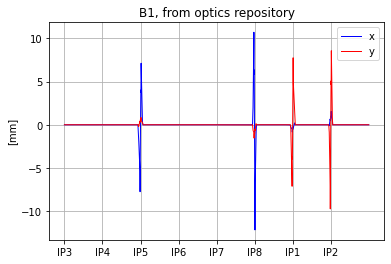

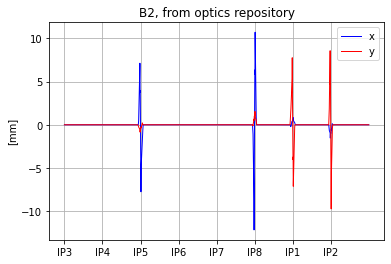

In [15]:
if parameter_dict['par_verbose']:
    for my_table, my_title in zip(['twiss_bare_optics_b1',
                                'twiss_bare_optics_b2'],
                                ['B1, from optics repository', 
                                'B2, from optics repository']):
        aux = mt.table_df(mad.table[my_table])
        plt.figure()
        plt.plot(aux.s,aux.x*1e3,'b', lw=1, label='x')
        plt.plot(aux.s,aux.y*1e3,'r',lw=1, label='y')
        plt.title(my_title)
        plt.xticks([aux.loc['ip3:1'].s,
            aux.loc['ip4:1'].s,
            aux.loc['ip5:1'].s,
            aux.loc['ip6:1'].s,
            aux.loc['ip7:1'].s,
            aux.loc['ip8:1'].s,
            aux.loc['ip1:1'].s,
            aux.loc['ip2:1'].s],['IP'+str(x) for x in [3,4,5,6,7,8,1,2]])
        plt.legend(loc='best')
        plt.grid(True)
        plt.ylabel('[mm]')

#### Sanity checks on_sep and on_x with bare optics

In [16]:
knobs_suffix = [['',''], ['',''], ['v', 'h'], ['h', 'v'] ] # the default knobs for run 3, not needed for HL

for beam, sign in zip([1,2], [1, -1]):
    for ip, suf in zip([1, 5, 2, 8], knobs_suffix):
        # Do not run if knobs are initialized to 0 in the optics files
        if (abs(mad.globals[f'on_x{ip}{suf[0]}'])>0) and (abs(mad.globals[f'on_sep{ip}{suf[1]}'])>0):
            aux = mt.table_df(mad.table[f'twiss_bare_optics_b{beam}'])
            if abs(aux.loc[f'ip{ip}:1']['px'])>abs(aux.loc[f'ip{ip}:1']['py']):
                    crossing_plane   = 'x'
                    separation_plane = 'y'
            else:
                    crossing_plane   = 'y'
                    separation_plane = 'x'

            # check both sign and value with rtol to 1e-2
            assert np.isclose(aux.loc[f'ip{ip}:1'][f'p{crossing_plane}']*1e6, sign*mad.globals[f'on_x{ip}{suf[0]}'], rtol=1e-2), f'Crossing angles from twiss do not match the ones from optics files in {beam} IP{ip}.'
            assert np.isclose(aux.loc[f'ip{ip}:1'][f'{separation_plane}']*1e3, sign*mad.globals[f'on_sep{ip}{suf[1]}'], rtol=1e-2), f'Separation from twiss does not match the one from optics file in in {beam} IP{ip}.'
        else:
            print(f'Did not run for IP{ip}.')

### Setting the crossing angles and separations

In [17]:
# This is the relation from DA studies from Nikos and Stéphane.
def from_beta_to_xing_angle_urad(beta_m):
    return  0.5*(132.47 + 58.3959 * np.sqrt(beta_m) + 30.0211 * beta_m)/np.sqrt(beta_m)

knob_dict={
    'on_sep1': 0,  
    'on_sep5': 0,         
    'on_sep2h': 1,
    'on_sep2v': 0,
    'on_x2h': 0,
    'on_x2v': 200,
    'on_sep8h': 0,
    'on_sep8v': 1,
    'on_x8h': 0,
    'on_x8v': 135,
    'on_disp': 1,
    'on_alice': 7000/parameter_dict['par_beam_energy_tot'],
    'on_lhcb': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_atlas': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_cms': 7000/parameter_dict['par_beam_energy_tot'],
    'on_sol_alice': 7000/parameter_dict['par_beam_energy_tot'],
}

betx_ip1 = mad.globals['betx_ip1']
knob_dict['on_x1'] = from_beta_to_xing_angle_urad(betx_ip1)
knob_dict['on_x5'] = from_beta_to_xing_angle_urad(betx_ip1)

for i in mask_dict.keys():
    if i in knob_dict.keys():
        print(f'Set {i}')
        knob_dict[i] = mask_dict[i]

for i in knob_dict:
    mad.input(f'{i} = {knob_dict[i]};')

mad.input('on_sep8=on_sep8v;')
mad.input('on_sep2=on_sep2h;')

True

### Saving the reference CO

In [18]:
# %% Sanity checks for new knobs
tol = 1e-15
for ip in [2, 8]:
    assert (abs(mad.globals[f'on_sep{ip}h'])>0 and abs(mad.globals[f'on_sep{ip}v'])<tol ) or (abs(mad.globals[f'on_sep{ip}v'])>0 and abs(mad.globals[f'on_sep{ip}h'])<tol ), 'Separation at both planes is not supported at the moment' 
    assert (abs(mad.globals[f'on_x{ip}h'])>0 and abs(mad.globals[f'on_x{ip}v'])<tol ) or (abs(mad.globals[f'on_x{ip}v'])>0 and abs(mad.globals[f'on_x{ip}h'])<tol ), 'Crossing at both planes is not supported at the moment' 


my_workflow_dict['save_crossing'] = run_module(mad,'module_01_save_crossing.madx')
execution_df=pd.DataFrame(my_workflow_dict).transpose()

#### Check of the CO
We plots the CO to verify it with the crossing angle enable/disabled.

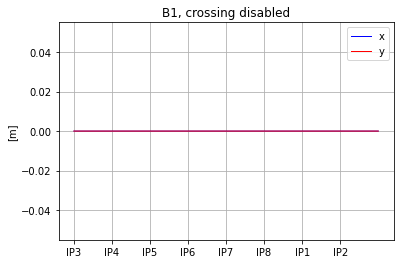

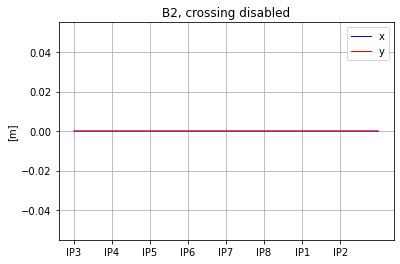

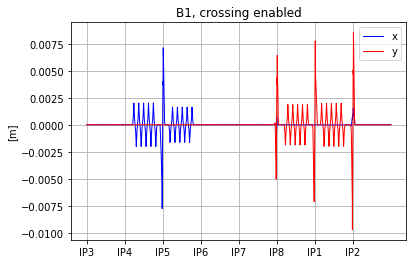

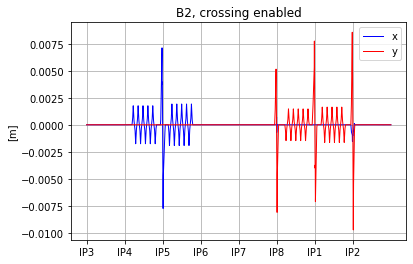

In [19]:
# %% Usual plots on orbits
if parameter_dict['par_verbose']:
    for my_table, my_title in zip(['twiss_crossing_disable_b1',
                                'twiss_crossing_disable_b2',
                                'twiss_crossing_enable_b1',
                                'twiss_crossing_enable_b2'],
                                ['B1, crossing disabled', 
                                'B2, crossing disabled',
                                'B1, crossing enabled',
                                'B2, crossing enabled']):
        aux = mt.table_df(mad.table[my_table])
        plt.figure()
        plt.plot(aux.s,aux.x,'b', lw=1, label='x')
        plt.plot(aux.s,aux.y,'r',lw=1, label='y')
        plt.title(my_title)
        plt.xticks([aux.loc['ip3:1'].s,
            aux.loc['ip4:1'].s,
            aux.loc['ip5:1'].s,
            aux.loc['ip6:1'].s,
            aux.loc['ip7:1'].s,
            aux.loc['ip8:1'].s,
            aux.loc['ip1:1'].s,
            aux.loc['ip2:1'].s],['IP'+str(x) for x in [3,4,5,6,7,8,1,2]])
        plt.legend(loc='best')
        plt.grid(True)
        plt.ylabel('[m]')

In [20]:
# %% Numerical check of the CO with crossing angle disabled
for my_table in ['twiss_crossing_disable_b1',
              'twiss_crossing_disable_b2']:
    aux = mt.table_df(mad.table[my_table])
    assert (all(aux.x<1e-6) and all(aux.y<1e-6)), 'Crossing disable is not working properly'

### Optics plots

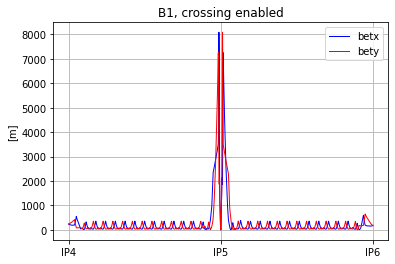

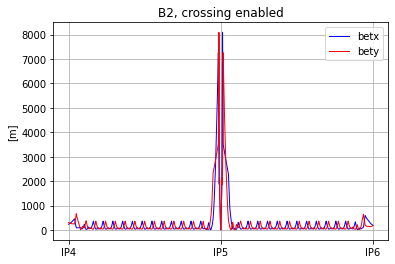

In [21]:
if parameter_dict['par_verbose']:
    for my_table, my_title in zip(['twiss_crossing_enable_b1',
                                'twiss_crossing_enable_b2'],
                                ['B1, crossing enabled',
                                'B2, crossing enabled']):
        aux = mt.table_df(mad.table[my_table])
        aux = aux.loc['ip4:1':'ip6:1'] # smart filtering
        plt.figure()
        plt.plot(aux.s,aux.betx,'b', lw=1, label='betx')
        plt.plot(aux.s,aux.bety,'r',lw=1, label='bety')
        plt.title(my_title)
        plt.xticks([aux.loc['ip4:1'].s,
                aux.loc['ip5:1'].s,
                aux.loc['ip6:1'].s],
                ['IP'+str(x) for x in [4,5,6]])
        plt.legend(loc='best')
        plt.grid(True)
        plt.ylabel('[m]')

One can also plot the bending and gradients (to get also an overview on the makethin).

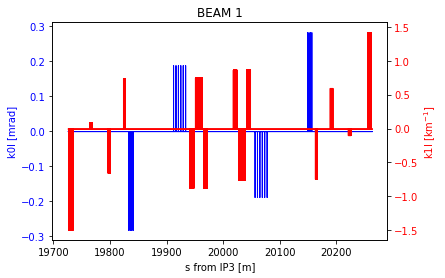

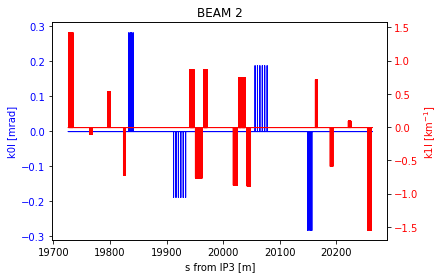

In [22]:
if parameter_dict['par_verbose']:
    for beam in ['1','2']:
        aux = mt.table_df(mad.table['twiss_crossing_enable_b'+beam])
        aux=aux.loc['e.ds.l1.b'+beam+':1':'s.ds.r1.b'+beam+':1']
        plt.figure()
        plt.fill_between(aux['s'],aux['k0l']*1e3,step="pre",color='b')
        ax1=plt.gca()
        ax1.set_ylabel('k0l [mrad]', color='b') 
        ax1.tick_params(axis='y', labelcolor='b')
        ax2 = ax1.twinx() 
        ax2.fill_between(aux['s'],aux['k1l']*1e3,step="pre",color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        ax2.set_ylabel('k1l [km$^{-1}$]', color='r') 
        plt.title('BEAM '+beam)
        ax1.set_xlabel('s from IP3 [m]')

#### Survey checks

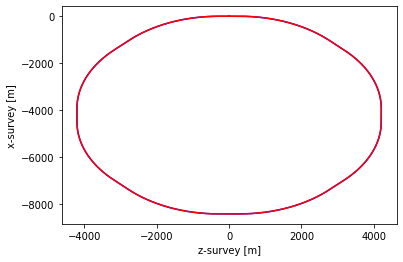

In [23]:
mad.input('''
use,sequence=lhcb1; 
survey, x0=-0.112;''')
survey_b1=mt.twiss_df(mad.table.survey)
mad.input('''
use,sequence=lhcb2; 
survey, x0=0.112;''')
survey_b2=mt.twiss_df(mad.table.survey)

#survey_b1_filtered=survey_b1['e.ds.l1.b1:1':'s.ds.r1.b1:1']
survey_b1_filtered=survey_b1
plt.plot(survey_b1_filtered['z'],survey_b1_filtered['x'],'b')
#survey_b2_filtered=survey_b2['e.ds.l1.b2:1':'s.ds.r1.b2:1']
survey_b2_filtered=survey_b2
if parameter_dict['par_verbose']:
    plt.plot(survey_b2_filtered['z'],survey_b2_filtered['x'],'r')
    plt.xlabel('z-survey [m]')
    plt.ylabel('x-survey [m]')

assert (np.isclose(survey_b1_filtered['z'].iloc[0], survey_b1_filtered['z'].iloc[-1], atol=1e-3) and np.isclose(survey_b1_filtered['x'].iloc[0], survey_b1_filtered['x'].iloc[-1], atol=1e-3)), 'Problem with survey in B1'
assert (np.isclose(survey_b2_filtered['z'].iloc[0], survey_b2_filtered['z'].iloc[-1], atol=1e-3) and np.isclose(survey_b2_filtered['x'].iloc[0], survey_b2_filtered['x'].iloc[-1], atol=1e-3)), 'Problem with survey in B2'


### Additional checks on the CO at the IPs

In [24]:
# %% Sanity checks on_sep and on_x with BB, before levelling
for beam, sign in zip([1,2], [1, -1]):
    for ip in [1, 5]:
        # Do not run if knobs are initialized to 0
        if (abs(mad.globals[f'on_x{ip}'])>0) and (abs(mad.globals[f'on_sep{ip}'])>0):
            aux = mt.table_df(mad.table[f'twiss_crossing_enable_b{beam}'])
            if abs(aux.loc[f'ip{ip}:1']['px'])>abs(aux.loc[f'ip{ip}:1']['py']):
                    crossing_plane   = 'x'
                    separation_plane = 'y'
            else:
                    crossing_plane   = 'y'
                    separation_plane = 'x'

            assert np.isclose(aux.loc[f'ip{ip}:1'][f'p{crossing_plane}']*1e6, sign*mad.globals[f'on_x{ip}'], rtol=1e-2), f'Crossing angles from twiss do not match the ones from optics files in {beam} IP{ip}.'
            assert np.isclose(aux.loc[f'ip{ip}:1'][f'{separation_plane}']*1e3, sign*mad.globals[f'on_sep{ip}'], rtol=1e-2), f'Separation from twiss does not match the one from optics file in in {beam} IP{ip}.'
        else:
            print(f'Test was not performed for IP{ip} (beam {beam}).')

Test was not performed for IP1 (beam 1).
Test was not performed for IP5 (beam 1).
Test was not performed for IP1 (beam 2).
Test was not performed for IP5 (beam 2).


In [25]:
# %% Retrieve internal crossing angle for IP2 and IP8 with the new knobs
mad.input('on_x8=on_x8h;') # I do this to remove the suffixes from the sanity checks
mad.input('on_x2=on_x2v;')

for beam, sign in zip([1,2], [1, -1]):
    for ip in [2, 8]:
        # Do not run if knobs are initialized to 0
        if (abs(mad.globals[f'on_x{ip}'])>0) and (abs(mad.globals[f'on_sep{ip}'])>0):
            aux = mt.table_df(mad.table[f'twiss_crossing_enable_b{beam}'])
            if abs(aux.loc[f'ip{ip}:1']['px'])>abs(aux.loc[f'ip{ip}:1']['py']):
                    crossing_plane   = 'x'
                    separation_plane = 'y'
            else:
                    crossing_plane   = 'y'
                    separation_plane = 'x'
            vec_momenta  = np.array([aux.loc[f'ip{ip}:1']['px']*1e6, aux.loc[f'ip{ip}:1']['py']*1e6]) 
            vec_onx      = np.array([sign*mad.globals[f'on_x{ip}h'], sign*mad.globals[f'on_x{ip}v']])
            vec_internal = (vec_momenta-vec_onx)
            print(f'Internal xing in IP{ip} is {round(vec_internal[0],3)} urad (horizontal) and {round(vec_internal[1],3)} urad (vertical).') 
        else:
            print(f'Test was not performed for IP{ip} (beam {beam}).')

Internal xing in IP2 is 0.288 urad (horizontal) and 70.006 urad (vertical).
Test was not performed for IP8 (beam 1).
Internal xing in IP2 is -0.29 urad (horizontal) and -70.053 urad (vertical).
Test was not performed for IP8 (beam 2).


In [26]:
# %% Sanity checks on_sep for IP2 and 8
for beam, sign in zip([1,2], [1, -1]):
    for ip in [2, 8]:
        # Do not run if knobs are initialized to 0
        if (abs(mad.globals[f'on_x{ip}'])>0) and (abs(mad.globals[f'on_sep{ip}'])>0):
            aux = mt.table_df(mad.table[f'twiss_crossing_enable_b{beam}'])
            if abs(aux.loc[f'ip{ip}:1']['px'])>abs(aux.loc[f'ip{ip}:1']['py']):
                    crossing_plane   = 'x'
                    separation_plane = 'y'
            else:
                    crossing_plane   = 'y'
                    separation_plane = 'x'
            assert np.isclose(aux.loc[f'ip{ip}:1'][f'{separation_plane}']*1e3, sign*mad.globals[f'on_sep{ip}'], rtol=1e-2), f'Separation from twiss does not match the one from optics file in in {beam} IP{ip}'
        else:
            print(f'Test was not performed for IP{ip} (beam {beam}).')

Test was not performed for IP8 (beam 1).
Test was not performed for IP8 (beam 2).


### Luminosity leveling in IP8

In [27]:
# %% Running the leveling and the beam-beam
print('Values BEFORE IP8 leveling:')
for i in ['on_sep8','on_sep8h','on_sep8v','on_sep2','on_sep2h','on_sep2v']:
    print(f'{i}: {mad.globals[i]}')
my_workflow_dict['lumilevel'] = run_module(mad,'module_02_lumilevel.madx')
mad.input('on_sep8v=on_sep8;')
mad.input('on_sep2h=on_sep2;')

print('Values AFTER IP8 leveling:')
for i in ['on_sep8','on_sep8h','on_sep8v','on_sep2','on_sep2h','on_sep2v']:
    print(f'{i}: {mad.globals[i]}')

Values BEFORE IP8 leveling:
on_sep8: 1.0
on_sep8h: 0.0
on_sep8v: 1.0
on_sep2: 1.0
on_sep2h: 1.0
on_sep2v: 0.0
Values AFTER IP8 leveling:
on_sep8: 0.02195981734149674
on_sep8h: 0.0
on_sep8v: 0.02195981734149674
on_sep2: 0.14470354136711136
on_sep2h: 0.14470354136711136
on_sep2v: 0.0


### Installing the BB lenses

In [28]:
my_workflow_dict['beambeam'] = run_module(mad,'module_03_beambeam.madx')
execution_df=pd.DataFrame(my_workflow_dict).transpose()

In [29]:
# %% From Sofia: check the luminosity
summary = {}
twiss = {}
beams = {}
for beam in [1,2]:
    summary[f'B{beam}'] = mt.summ_df(mad.table[f'summary_beambeam_b{beam}'])
    twiss[f'B{beam}'] = mt.table_df(mad.table[f'twiss_beambeam_b{beam}'])
    beams[f'B{beam}'] = mt.beams_df(mad).loc[[f'lhcb{beam}']]

def cmp_luminosity_0(intensity, bunches, sigma_X, sigma_P, frev=11245.5):
    return (intensity**2*bunches*frev)/(4.0*np.pi*sigma_X*sigma_P)

def crossing_factor(phi, sigmaz, sigma_X):
    return 1./np.sqrt(1. + (sigmaz*phi/2.)**2/(sigma_X**2)  )

def offset_factor(halo):
    a  = -(halo/ 2.)**2
    return np.exp(a)

def cmp_luminosity(intensity, bunches, sigma_X, sigma_P, phi, sigmaz, halo,frev=11245.5):
    crossing = crossing_factor(phi, sigmaz, sigma_X)
    offset   = offset_factor(halo)
    return cmp_luminosity_0(intensity, bunches, sigma_X, sigma_P, frev)*crossing*offset

#def luminous_region(phi, sigmaz, sigma_X):
#    return sigmaz/np.sqrt(2.)*crossing_factor(phi, sigmaz, sigma_X)

print('1st formula')
############# This is the lumi formula for a crossing strictly in x or y
for beam in [1, 2]:
    print("Beam %s" %beam)
    for nIP in [1, 2, 5, 8 ]:
        intensity    = beams[f'B{beam}']['npart'].values[0]
        bunch_length = beams[f'B{beam}']['sigt'].values[0]
        egeom_x      = beams[f'B{beam}']['ex'].values[0]
        egeom_y      = beams[f'B{beam}']['ey'].values[0]

        bunches   = mad.globals.get('nco_IP%s' %nIP)
        beta_x    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['betx']
        beta_y    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['bety']
        sigma_x   = np.sqrt(egeom_x*beta_x)
        sigma_y   = np.sqrt(egeom_y*beta_y)

        offlvl_px = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['px']
        offlvl_py = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['py']

        offlvl_x  = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['x']
        offlvl_y  = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['y']

        if abs(offlvl_px)>abs(offlvl_py):
            phi        = 2.0*offlvl_px
            sigma_Xing = sigma_x
            sigma_Par  = sigma_y
            halo =  2.0*offlvl_y/sigma_x

        else:
            phi        = 2.0*offlvl_py
            sigma_Xing = sigma_y
            sigma_Par  = sigma_x
            halo =  2.0*offlvl_x/sigma_x


        print('Luminosity in IP%s: %s Hz/cm^2'%(nIP, cmp_luminosity(intensity, bunches, sigma_Xing, sigma_Par, phi, bunch_length, halo)*1e-4))
print("")
print('2nd formula')
############### This is the general lumi formula that can be used during the whole beam process of the LHb rotation ONLY FOR ROUND BEAMS
for beam in [1, 2]:
    print("Beam %s" %beam)
    for nIP in [1, 2, 5, 8]:
        intensity    = beams[f'B{beam}']['npart'].values[0]
        bunch_length = beams[f'B{beam}']['sigt'].values[0]
        egeom_x      = beams[f'B{beam}']['ex'].values[0]
        egeom_y      = beams[f'B{beam}']['ey'].values[0]

        bunches   = mad.globals.get('nco_IP%s' %nIP)
        beta_x    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['betx']
        beta_y    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['bety']
        sigma_x   = np.sqrt(egeom_x*beta_x)
        sigma_y   = np.sqrt(egeom_y*beta_y)
        
        assert np.isclose(sigma_x, sigma_y, rtol=1e-4), 'Not round beam!'

        offlvl_px = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['px']
        offlvl_py = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['py']

        offlvl_x  = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['x']
        offlvl_y  = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['y']

        if abs(offlvl_px)>abs(offlvl_py):
            phi        = 2.0*np.sqrt(offlvl_px**2 + offlvl_py**2)
            sigma_Xing = sigma_x
            sigma_Par  = sigma_y
            halo =  2.0*offlvl_y/sigma_x

        else:
            phi        = 2.0*np.sqrt(offlvl_py**2 + offlvl_px**2)
            sigma_Xing = sigma_y
            sigma_Par  = sigma_x
            halo =  2.0*offlvl_x/sigma_x


        print('Luminosity in IP%s: %s Hz/cm^2'%(nIP, cmp_luminosity(intensity, bunches, sigma_Xing, sigma_Par, phi, bunch_length, halo)*1e-4))


1st formula
Beam 1
Luminosity in IP1: 2.0030573855967268e+34 Hz/cm^2
Luminosity in IP2: 1.4844706057456384e+30 Hz/cm^2
Luminosity in IP5: 2.002883268866162e+34 Hz/cm^2
Luminosity in IP8: 5.22058559377143e+33 Hz/cm^2
Beam 2
Luminosity in IP1: 2.0019624752343005e+34 Hz/cm^2
Luminosity in IP2: 1.5066394480701458e+30 Hz/cm^2
Luminosity in IP5: 2.0028082726605698e+34 Hz/cm^2
Luminosity in IP8: 5.219147239482237e+33 Hz/cm^2

2nd formula
Beam 1
Luminosity in IP1: 2.0030572972268331e+34 Hz/cm^2
Luminosity in IP2: 1.4844705096298292e+30 Hz/cm^2
Luminosity in IP5: 2.0028824112762287e+34 Hz/cm^2
Luminosity in IP8: 4.829178965629554e+33 Hz/cm^2
Beam 2
Luminosity in IP1: 2.001962374315475e+34 Hz/cm^2
Luminosity in IP2: 1.5066393563714283e+30 Hz/cm^2
Luminosity in IP5: 2.0028072285911635e+34 Hz/cm^2
Luminosity in IP8: 4.8278884663499543e+33 Hz/cm^2


#### Sanity check of IP2 luminosity

In [30]:
for beam, sign in zip([1,2], [1, -1]):
    nIP = 2
    aux = mt.table_df(mad.table[f'twiss_beambeam_b{beam}'])
    beta_x    = aux.loc[f'ip{nIP}:1']['betx']
    sigma_x   = np.sqrt(egeom_x*beta_x)
    offlvl_x  = aux.loc[f'ip{nIP}:1']['x']
    halo =  2.0*offlvl_x/sigma_x
    assert np.isclose(halo, sign*mad.globals['halo2'], rtol=1e-2), f'Halo in IP2 not reached for B{beam}'

#### Sanity check of IP8 luminosity

!!! Danger
    We skip this test. To be fixed.

In [31]:
if False:
    for beam in [1, 2]:
        print("Beam %s" %beam)
        nIP = 8
        intensity    = beams[f'B{beam}']['npart'].values[0]
        bunch_length = beams[f'B{beam}']['sigt'].values[0]
        egeom_x      = beams[f'B{beam}']['ex'].values[0]
        egeom_y      = beams[f'B{beam}']['ey'].values[0]

        bunches   = mad.globals.get('nco_IP%s' %nIP)
        beta_x    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['betx']
        beta_y    = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['bety']
        sigma_x   = np.sqrt(egeom_x*beta_x)
        sigma_y   = np.sqrt(egeom_y*beta_y)

        assert np.isclose(sigma_x, sigma_y, rtol=1e-4), 'Not round beam!'

        offlvl_px = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['px']
        offlvl_py = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['py']

        offlvl_x  = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['x']
        offlvl_y  = twiss[f'B{beam}'].loc[f'ip{nIP}:1']['y']

        if abs(offlvl_px)>abs(offlvl_py):
            phi        = 2.0*np.sqrt(offlvl_px**2 + offlvl_py**2)
            sigma_Xing = sigma_x
            sigma_Par  = sigma_y
            halo =  2.0*offlvl_y/sigma_x
        else:
            phi        = 2.0*np.sqrt(offlvl_py**2 + offlvl_px**2)
            sigma_Xing = sigma_y
            sigma_Par  = sigma_x
            halo =  2.0*offlvl_x/sigma_x

        assert np.isclose(cmp_luminosity(intensity, bunches, sigma_Xing, sigma_Par, phi, bunch_length, halo)*1e-4, parameter_dict['par_lumi_ip8'], rtol=1e-2 ), 'Lumi levelling in IP8 failed!'

### Final tuning and last twiss

In [32]:
# %% Machine tuning and last twiss

my_sequence_df=mt.sequence_df(mad, 'lhcb1')

assert mad.globals['mylhcbeam'] == 1

assert len(mt.knob_df('dqx.b1_sq',my_sequence_df)) > 0
assert len(mt.knob_df('kqtf',my_sequence_df)) == 0

assert len(mt.knob_df('vrf400',my_sequence_df)) > 0

assert mad.globals['dqx.b1_sq'] == 0
assert mad.globals['dqy.b1_sq'] == 0
assert mad.globals['dqx.b2_sq'] == 0
assert mad.globals['dqy.b2_sq'] == 0

mad.input('dqx.b1_sq := kqtf;')
mad.input('dqy.b1_sq := kqtd;')

assert mad.globals['dqpx.b1_sq'] == 0
assert mad.globals['dqpy.b1_sq'] == 0
assert mad.globals['dqpx.b2_sq'] == 0
assert mad.globals['dqpy.b2_sq'] == 0

mad.input('dqpx.b1_sq := ksf;')
mad.input('dqpy.b1_sq := ksd;')

my_workflow_dict['machine_tuning'] = run_module(mad,'module_05_machine_tuning.madx')
my_workflow_dict['make_sixtrack_input'] = run_module(mad,'module_06_make_sixtrack_input.madx')
my_workflow_dict['last_twiss.madx'] = run_module(mad,'module_07_last_twiss.madx')

execution_df=pd.DataFrame(my_workflow_dict).transpose()

#### Convergence plots

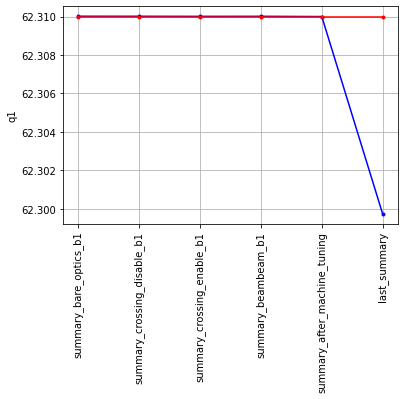

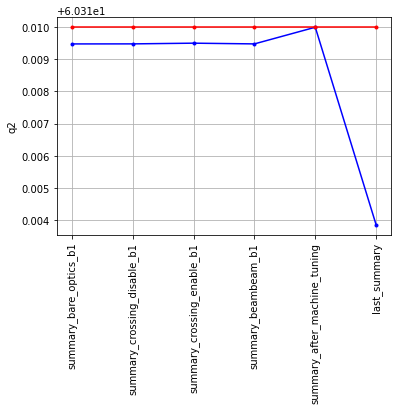

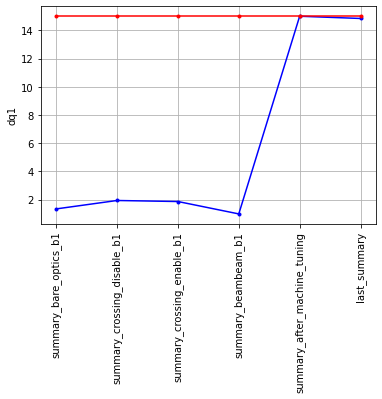

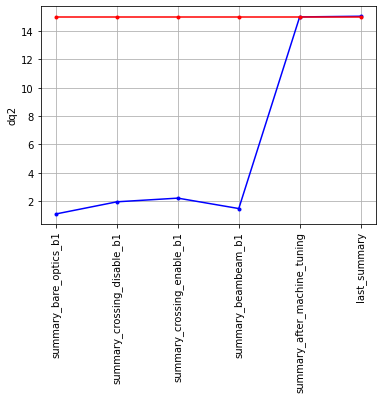

In [33]:
summary_df = pd.DataFrame()
for my_summary in ['summary_bare_optics_b1',
                  'summary_crossing_disable_b1',
                  'summary_crossing_enable_b1',
                  'summary_beambeam_b1',
                  'summary_after_machine_tuning',
                  'last_summary']:
    summary_df = pd.concat([summary_df, mt.summ_df(mad.table[my_summary])])

summary_df['par_qx0']=parameter_dict['par_qx0']
summary_df['par_qy0']=parameter_dict['par_qy0']
summary_df['par_chromaticity']=parameter_dict['par_chromaticity']

if parameter_dict['par_verbose']:
    for my_quantity, my_parameter in zip(['q1','q2','dq1','dq2'],
                                        ['par_qx0','par_qy0','par_chromaticity','par_chromaticity']):
        plt.figure()
        plt.plot(summary_df[my_quantity],'.-b')
        plt.plot(summary_df[my_parameter],'.--r')

        plt.xticks(rotation=90)
        plt.ylabel(my_quantity)
        plt.grid(True)


### Final checks
#### Checks of the Q and DQ

In [34]:
# %% Check if chroma and tune matching are ok
aux = mt.summ_df(mad.table[f'summary_after_machine_tuning'])
assert np.isclose(aux['q1'].values[0], parameter_dict['par_qx0'],rtol=1e-3),'Horizontal tune check after matching failed'
assert np.isclose(aux['q2'].values[0], parameter_dict['par_qy0'],rtol=1e-3),'Vertical tune check after matching failed'
assert np.isclose(aux['dq1'].values[0], parameter_dict['par_chromaticity'], rtol=1e-3), 'Chroma check after matching failed'
assert np.isclose(aux['dq2'].values[0], parameter_dict['par_chromaticity'], rtol=1e-3), 'Chroma check after matching failed'

#### Checks of the voltage and I_MO

In [35]:
# %%
if False: # for ad-hoc use if needed
    my_sequence_df=mt.sequence_df(mad, 'lhcb1')
    mt.knob_df('vrf400',my_sequence_df)
    _ = mt.show_element('acsca.d5r4.b1',my_sequence_df)
    mt.knob_df('i_mo',my_sequence_df)
    
assert mad.globals['vrf400'] == parameter_dict['par_vrf_total']
assert mad.globals['i_mo'] == parameter_dict['par_oct_current']

#### Check on the orbit stability

In [36]:
# Check the orbit stability
ip_list=['ip1:1','ip2:1','ip5:1','ip8:1']
columns_list=['s','x','px','y','py']
twiss_beambeam_b1=mt.twiss_df(mad.table.twiss_beambeam_b1)
display(twiss_beambeam_b1.loc[ip_list][columns_list])

last_twiss=mt.twiss_df(mad.table.last_twiss)
display(last_twiss.loc[ip_list][columns_list])

last_twiss.loc[ip_list][columns_list]-twiss_beambeam_b1.loc[ip_list][columns_list]

s             x            px             y            py
                                                                           
ip1:1  19994.162400  2.619309e-08  6.156103e-08  4.815329e-08  1.584125e-04
ip2:1  23326.598984  1.448456e-04  2.943653e-07 -1.895586e-07  2.700098e-04
ip5:1   6664.568433 -4.028944e-08  1.583844e-04 -4.466118e-08 -1.917847e-07
ip8:1  16650.658184  6.373523e-08  1.349955e-04  2.205481e-05  1.369151e-04

s             x            px             y            py
                                                                           
ip1:1  19994.162400  2.619303e-08  6.156092e-08  4.815319e-08  1.584125e-04
ip2:1  23326.598984  1.448456e-04  2.943653e-07 -1.895583e-07  2.700098e-04
ip5:1   6664.568433 -4.028948e-08  1.583844e-04 -4.466117e-08 -1.917843e-07
ip8:1  16650.658184  6.373495e-08  1.349955e-04  2.205481e-05  1.369151e-04

s             x            px             y            py
                                                                  
ip1:1  0.0 -5.860604e-14 -1.154283e-13 -9.869737e-14 -2.118252e-13
ip2:1  0.0 -2.018764e-13  3.368607e-14  3.714394e-13  3.407393e-14
ip5:1  0.0 -4.264132e-14 -1.762588e-13  1.849282e-14  4.149088e-13
ip8:1  0.0 -2.817191e-13 -2.703756e-14 -1.057013e-13 -1.737870e-13

#### Check on the crossing angle

In [37]:
# Checks of IP1/5 crossing angles
aux=last_twiss.loc['ip1:1']['py']/(knob_dict['on_x1']*1e-6)
assert aux>.9
assert abs(aux-1) < 0.001

aux=last_twiss.loc['ip5:1']['px']/(knob_dict['on_x5']*1e-6)
assert aux>.9
assert abs(aux-1) < 0.001

In [38]:
# %% Checks of IP2 crossing angles
aux=mad.globals['on_alice']
mad.input('on_alice=0;')
mad.input('twiss, table=my_test;')
mad.input(f'on_alice={aux};')

ip_list=['ip2:1']
columns_list=['s','x','px','y','py']
my_test=mt.twiss_df(mad.table.my_test)
display(my_test.loc[ip_list][columns_list])
aux=my_test.loc['ip2:1']['px']/(knob_dict['on_x2h']*1e-6)
assert abs(my_test.loc['ip2:1']['px']) < 1e-6
aux=my_test.loc['ip2:1']['py']/(knob_dict['on_x2v']*1e-6)
assert aux>1
assert abs(aux-1) < 0.001

s         x            px             y      py
                                                                 
ip2:1  23326.598984  0.000145  2.828106e-09 -1.895223e-07  0.0002

/home/sterbini/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [39]:
# %% Check of IP8 crossing angles
aux=mad.globals['on_lhcb']
mad.input('on_lhcb=0;')
mad.input('twiss, table=my_test;')
mad.input(f'on_lhcb={aux};')

ip_list=['ip8:1']
columns_list=['s','x','px','y','py']
my_test=mt.twiss_df(mad.table.my_test)
display(my_test.loc[ip_list][columns_list])
aux=my_test.loc['ip8:1']['py']/(knob_dict['on_x8v']*1e-6)
assert aux>1
assert abs(aux-1) < 0.001

s             x            px         y        py
                                                                   
ip8:1  16650.658184  6.373487e-08  7.607577e-09  0.000022  0.000135

#### Check on the BB analysis

Summary of BB in IR1
HO encounters number: 11
LR encounters number: 42
Summary of BB in IR2
HO encounters number: 11
LR encounters number: 40
Summary of BB in IR5
HO encounters number: 11
LR encounters number: 42
Summary of BB in IR8
HO encounters number: 11
LR encounters number: 40


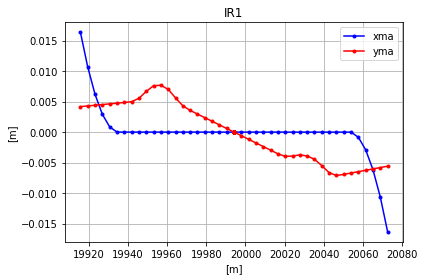

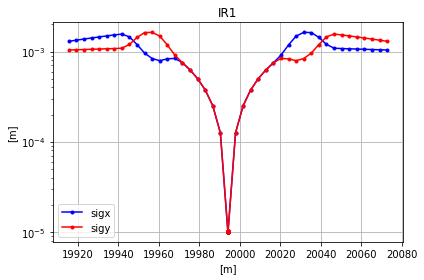

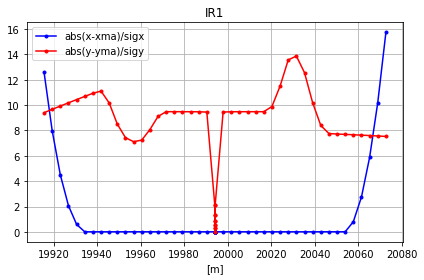

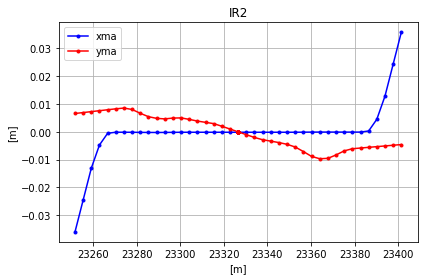

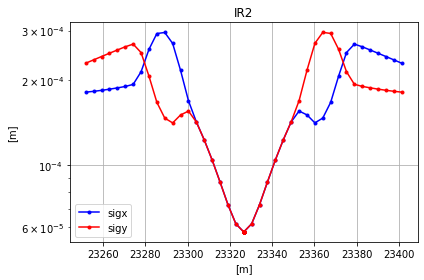

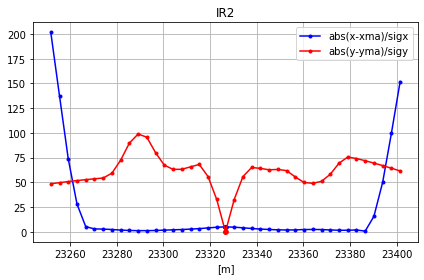

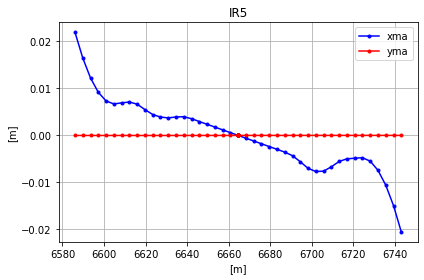

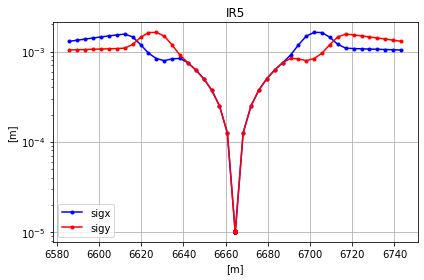

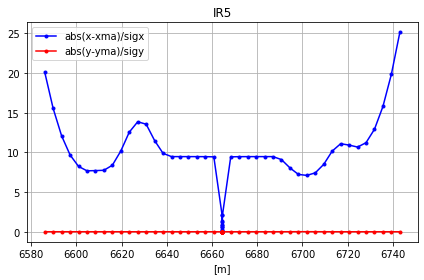

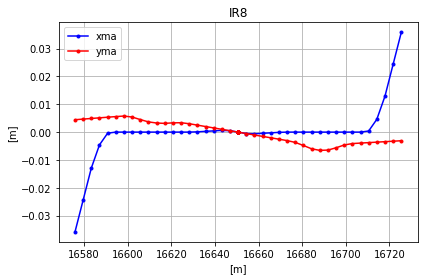

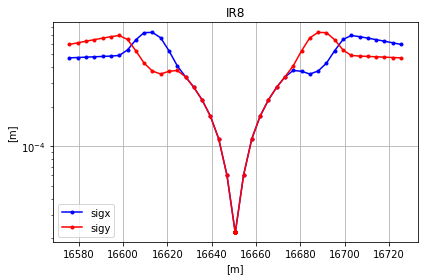

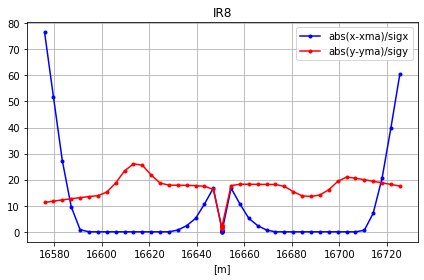

In [97]:
# %% BB analysis

last_twiss=mt.twiss_df(mad.table.last_twiss)
aux=last_twiss[last_twiss['keyword']=='beambeam']

for i in [1,2,5,8]:
    if parameter_dict['par_verbose']:
        fig=plt.figure()
        irDF=aux[aux.index.str.contains(f'{i}b1')]
        plt.plot(irDF['s'],irDF['xma'],'.-b', label='xma')
        plt.plot(irDF['s'],irDF['yma'],'.-r', label='yma')
        plt.legend(loc='best')
        plt.grid(True)
        plt.title(f'IR{i}')
        plt.xlabel('[m]')
        plt.ylabel('[m]')
        plt.tight_layout()


        fig=plt.figure()
        plt.semilogy(irDF['s'],irDF['sigx'],'.-b', label='sigx')
        plt.semilogy(irDF['s'],irDF['sigy'],'.-r', label='sigy')
        plt.legend(loc='best')
        plt.grid(True)
        plt.title(f'IR{i}')
        plt.xlabel('[m]')
        plt.ylabel('[m]')
        plt.tight_layout()



        fig=plt.figure()
        plt.plot(irDF['s'],abs(irDF['x']-irDF['xma'])/irDF['sigx'],'.-b', label='abs(x-xma)/sigx')
        plt.plot(irDF['s'],abs(irDF['y']-irDF['yma'])/irDF['sigy'],'.-r', label='abs(y-yma)/sigy')
        plt.legend(loc='best')
        plt.grid(True)
        plt.title(f'IR{i}')
        plt.xlabel('[m]')
        plt.tight_layout()



    print(f'Summary of BB in IR{i}')
    print(f'HO encounters number: {sum(irDF.index.str.contains("bb_ho"))}')
    print(f'LR encounters number: {sum(irDF.index.str.contains("bb_par"))}')
    print('=============================')